# IN6227 Assignment 1 — Decision Tree & Random Forest on Census Income Data

- Name: Fang Yuanjun Matric: G2503411F

## **Import and Set up**

In [51]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Load Dataset**

In [38]:
DATA_DIR = 'Census Income Data Set'
TRAIN_FILE = os.path.join(DATA_DIR, 'adult.data')
TEST_FILE  = os.path.join(DATA_DIR, 'adult.test')

COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

train_df = pd.read_csv(TRAIN_FILE, header=None, names=COLUMNS, sep=',', na_values=' ?', skipinitialspace=True)
test_df  = pd.read_csv(TEST_FILE, header=0, names=COLUMNS, sep=',', na_values=' ?', skipinitialspace=True)

print('Train shape:', train_df.shape)
print('Test shape :', test_df.shape)
train_df.head()

Train shape: (32561, 15)
Test shape : (16281, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## **Preprocessing**

In [39]:
# Merge train + test for a single consistent preprocessing pipeline

df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

df = df.drop(columns=['fnlwgt'])
df['income'] = df['income'].astype(str).str.replace('.', '', regex=False).str.strip()
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# Identify feature types
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['income']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train/test split (stratified)
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape

Numeric features: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical features: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


((34189, 13), (14653, 13))

## **Model Set**

In [ ]:
# Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=50, max_depth=10, n_jobs=-1))
])

# SVM with Linear Kernel + Probability Calibration
svm_linear = LinearSVC(random_state=42, max_iter=10000, dual=False)
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CalibratedClassifierCV(svm_linear, method='sigmoid', cv=3))
])

# LightGBM
lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1
    ))
])

## **Timer**

In [ ]:
def fit_predict_time(model, X_train, y_train, X_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_t = time.time() - t0
    t0 = time.time()
    y_pred = model.predict(X_test)
    pred_t = time.time() - t0
    
    y_prob = model.predict_proba(X_test)[:, 1]
    return train_t, pred_t, y_pred, y_prob

train_time_rf, predict_time_rf, y_pred_rf, y_prob_rf = fit_predict_time(rf_model, X_train, y_train, X_test)
train_time_svm, predict_time_svm, y_pred_svm, y_prob_svm = fit_predict_time(svm_model, X_train, y_train, X_test)
train_time_lgb, predict_time_lgb, y_pred_lgb, y_prob_lgb = fit_predict_time(
    lgbm_model, X_train, y_train, X_test
)
print(f'Training time  — RF : {train_time_rf:.3f}s'); print(f'Prediction time — RF : {predict_time_rf:.3f}s')
print(f'Training time  — SVM: {train_time_svm:.3f}s'); print(f'Prediction time — SVM: {predict_time_svm:.3f}s')
print(f"Training time  — LightGBM : {train_time_lgb:.3f}s")
print(f"Prediction time — LightGBM : {predict_time_lgb:.3f}s")

Training time  — RF : 0.323s
Prediction time — RF : 0.030s
Training time  — SVM: 0.338s
Prediction time — SVM: 0.021s
[LightGBM] [Info] Number of positive: 8181, number of negative: 26008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 34189, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239287 -> initscore=-1.156590
[LightGBM] [Info] Start training from score -1.156590
Training time  — LightGBM : 0.811s
Prediction time — LightGBM : 0.099s


## **Evaluation -Accuracy, Precision, Recall, F1**

In [50]:
def summarize(y_true, y_pred, name):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred)
    }

metrics_df = pd.DataFrame([
    summarize(y_test, y_pred_rf, 'Random Forest'),
    # summarize(y_test, y_pred_svm, 'SVM (Linear, calibrated)'),
    summarize(y_test, y_pred_lgb, 'LightGBM')
])
# metrics_df['Train_Time_s']   = [train_time_rf, train_time_svm, train_time_lgb]
# metrics_df['Predict_Time_s'] = [predict_time_rf, predict_time_svm, predict_time_lgb]
metrics_df['Train_Time_s']   = [train_time_rf, train_time_lgb]
metrics_df['Predict_Time_s'] = [predict_time_rf, predict_time_lgb]
metrics_df


,Model,Accuracy,Precision,Recall,F1,Train_Time_s,Predict_Time_s
0,Random Forest,0.859141,0.803707,0.544210,0.648980,0.323133,0.029956
1,LightGBM,0.875179,0.783373,0.661152,0.717092,0.810720,0.099118


## **Confusion Matrix**

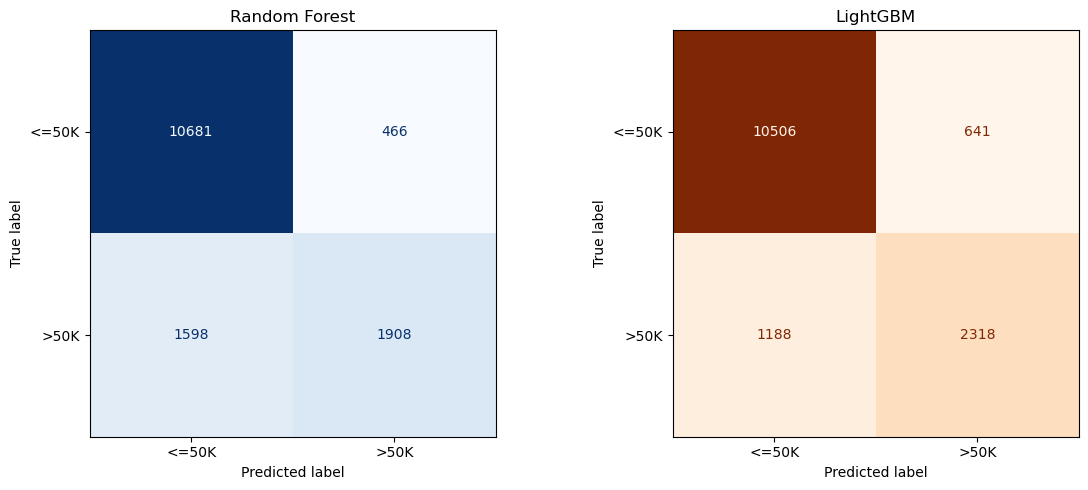

In [53]:
# 计算混淆矩阵
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# 创建画布，1行2列
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 随机森林
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=["<=50K", ">50K"])
disp_rf.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Random Forest")

# LightGBM
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb,
                                  display_labels=["<=50K", ">50K"])
disp_lgb.plot(cmap=plt.cm.Oranges, ax=axes[1], colorbar=False)
axes[1].set_title("LightGBM")

plt.tight_layout()
plt.show()

## **ROC & Precision-Recall Curves**

Random Forest ROC AUC: 0.9118718473159418 SVM Linear ROC AUC: 0.9044193728870694 LightGBM ROC AUC: 0.9295612294365638


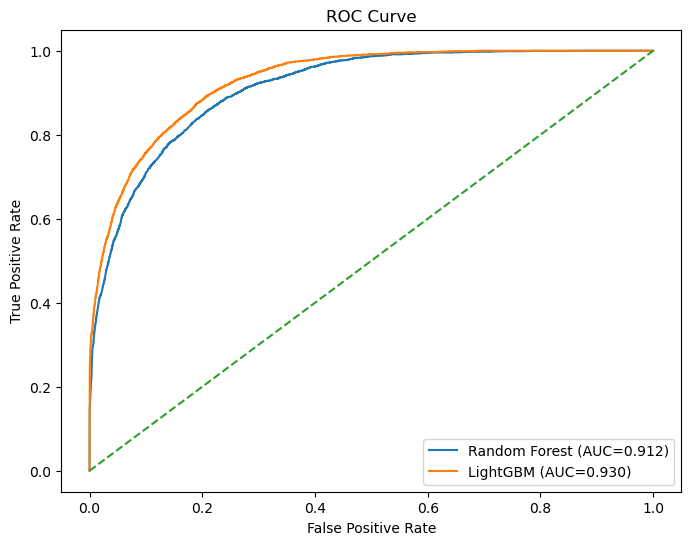

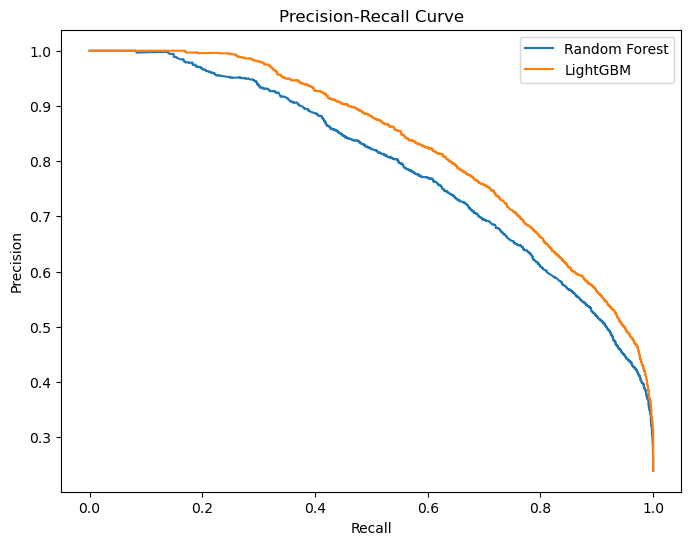

In [48]:
# ROC AUC
auc_rf  = roc_auc_score(y_test, y_prob_rf)
# auc_svm = roc_auc_score(y_test, y_prob_svm)
auc_gbm = roc_auc_score(y_test, y_prob_lgb)
print("Random Forest ROC AUC:", auc_rf, "SVM Linear ROC AUC:", auc_svm, "LightGBM ROC AUC:", auc_gbm)

# ROC Curves
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)
# fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_prob_lgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
# plt.plot(fpr_svm, tpr_svm, label=f'SVM Linear (AUC={auc_svm:.3f})')
plt.plot(fpr_gbm, tpr_gbm, label=f'LightGBM (AUC={auc_gbm:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.show()

# PR Curves
prec_rf,  rec_rf,  _ = precision_recall_curve(y_test, y_prob_rf)
# prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_prob_svm)
prec_gbm, rec_gbm, _ = precision_recall_curve(y_test, y_prob_lgb)
plt.figure(figsize=(8,6))
plt.plot(rec_rf,  prec_rf,  label='Random Forest')
# plt.plot(rec_svm, prec_svm, label='SVM Linear')
plt.plot(rec_gbm, prec_gbm, label='LightGBM')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve'); plt.legend(); plt.show()